# San Francisco Crime Classification

## Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

import folium

# import geopandas as gpd
# from shapely.geometry import Point
# from geopandas import GeoDataFrame


## Parameter definition

In [2]:
RAW_DATA = '../data/raw/' 
EXTERNAL_DATA = '../data/external/' 
INTERIM_DATA = '../data/interim/' 
PROCESSED_DATA = '../data/processed/'
REFERENCES = '../references/'
RANDOM_STATE = 14

## Data fields

Data fields
 - Dates - timestamp of the crime incident
 - **Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.**
 - **Descript - detailed description of the crime incident (only in train.csv)**
 - DayOfWeek - the day of the week
 - PdDistrict - name of the Police Department District
 - **Resolution - how the crime incident was resolved (only in train.csv)**
 - Address - the approximate street address of the crime incident 
 - X - Longitude
 - Y - Latitude

Public holidays in San Francisco

 - New Year's Day: 1st January.
 - Martin Luther King Jr Day: Third Monday of January.
 - Presidents' Day: Third Monday in February.
 - Memorial Day: Last Monday in May.
 - Independence Day: 4th July.
 - Labor Day: First Monday in September.
 - Columbus Day: Second Monday in October.
 - Veterans' Day: 11th November.
 - Thanksgiving: Last Thursday in November.
 - Christmas Day: 25th December.

## Learning dataset

In [3]:
df = pd.read_csv(RAW_DATA + 'train.csv')
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [5]:
df.isna().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
dtype: int64

There is no null value on train dataset.

In [6]:
# df.duplicated().sum()

In [7]:
# df.drop_duplicates(keep='first', inplace=True)
# df

In [8]:
for c in df.columns:
    print(c)
    print(df[c].value_counts())
    print('--'*40)

Dates
2011-01-01 00:01:00    185
2006-01-01 00:01:00    136
2012-01-01 00:01:00     94
2006-01-01 12:00:00     63
2007-06-01 00:01:00     61
                      ... 
2012-06-26 00:10:00      1
2012-06-26 00:16:00      1
2012-06-26 00:55:00      1
2012-06-26 01:06:00      1
2009-02-19 08:00:00      1
Name: Dates, Length: 389257, dtype: int64
--------------------------------------------------------------------------------
Category
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  

In [9]:
df.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [10]:
sum(df['Resolution'] == 'NONE')/len(df['Resolution'])*100

59.99551277889958

In [11]:
len(df['Category'].unique())

39

#TODO: create a summary with first impressions on dataset

- At Resolution column almost 60% of the data is NONE.
- There are 39 uniques types of Category.
- 9 categories correspond to more than 80 of the crimes. 

## Date in dataset

**Transforming Dates column from object to datetime**

In [12]:
df['Dates'] = pd.to_datetime(df['Dates'])
df['Dates']

0        2015-05-13 23:53:00
1        2015-05-13 23:53:00
2        2015-05-13 23:33:00
3        2015-05-13 23:30:00
4        2015-05-13 23:30:00
                 ...        
878044   2003-01-06 00:15:00
878045   2003-01-06 00:01:00
878046   2003-01-06 00:01:00
878047   2003-01-06 00:01:00
878048   2003-01-06 00:01:00
Name: Dates, Length: 878049, dtype: datetime64[ns]

In [13]:
#df['month'] = df['Dates'].apply(lambda dt: dt.month)
#df['day'] = df['Dates'].apply(lambda dt: dt.day)
#df['year'] = df['Dates'].apply(lambda dt: dt.year)
#df

In [14]:
df['month'] = df['Dates'].dt.month
df['day'] = df['Dates'].dt.day
df['year'] = df['Dates'].dt.year
df['hour'] = df['Dates'].dt.hour
#df['minute'] = df['Dates'].dt.minute
#df['time'] = df['Dates'].dt.time
df

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month,day,year,hour
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,5,13,2015,23
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,5,13,2015,23
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,5,13,2015,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,1,6,2003,0
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,1,6,2003,0
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,1,6,2003,0
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,1,6,2003,0


In [15]:
#Creating morning, afternoon, night and dawn
# condlist = [df['hour']<6, df['hour']<12, df['hour']<18]
# choicelist = ['dawn', 'morning', 'afternoon']
# df['day_period'] = np.select(condlist, choicelist, 'night')
# df['day_period'].value_counts()

In [16]:
df.iloc[582]

Dates                  2015-05-12 11:30:00
Category                     LARCENY/THEFT
Descript      GRAND THEFT FROM LOCKED AUTO
DayOfWeek                          Tuesday
PdDistrict                        SOUTHERN
Resolution                            NONE
Address             800 Block of BRYANT ST
X                              -122.403405
Y                                37.775421
month                                    5
day                                     12
year                                  2015
hour                                    11
Name: 582, dtype: object

In [17]:
def visualization_crime(value, tight=False):
    with plt.style.context('fivethirtyeight'):
        fig, ax = plt.subplots(1, 1, figsize=(19, 6))
        sns.histplot(x=value, data=df, kde=False, palette='rocket', ax=ax)
        ax.tick_params(axis='x', rotation=0)
        if tight == True:
            fig.tight_layout()

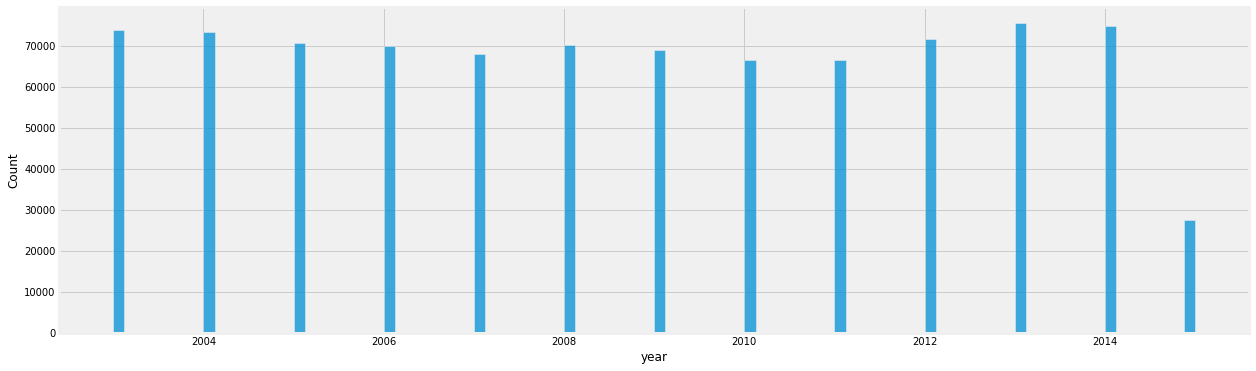

In [18]:
visualization_crime('year')

## Day of week

In [19]:
df['DayOfWeek'].value_counts()

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

#TODO: what information can I get from day of week?

## Category

In [20]:
df['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

## Address

In [21]:
df['Address'].unique()

array(['OAK ST / LAGUNA ST', 'VANNESS AV / GREENWICH ST',
       '1500 Block of LOMBARD ST', ..., '300 Block of JOHN F KENNEDY DR',
       'FOLSOM ST / ZENO PL', '1000 Block of 22ND AV'], dtype=object)

In [22]:
data = pd.DataFrame(df['Address'].value_counts().values.cumsum(axis=0)/df['Address'].value_counts().values.sum()*100)
data

,0
0,3.021813
1,3.771316
2,4.351807
3,4.814538
4,5.184790
...,...
23223,99.999544
23224,99.999658
23225,99.999772
23226,99.999886


In [23]:
df['Address'].value_counts()

800 Block of BRYANT ST           26533
800 Block of MARKET ST            6581
2000 Block of MISSION ST          5097
1000 Block of POTRERO AV          4063
900 Block of MARKET ST            3251
                                 ...  
PRECITA AV / CESAR CHAVEZ ST         1
0 Block of COLUSA PL                 1
2800 Block of KEITH ST               1
CABRILLO ST / ARGUELLO BL            1
OFARRELL ST / CYRIL MAGNIN ST        1
Name: Address, Length: 23228, dtype: int64

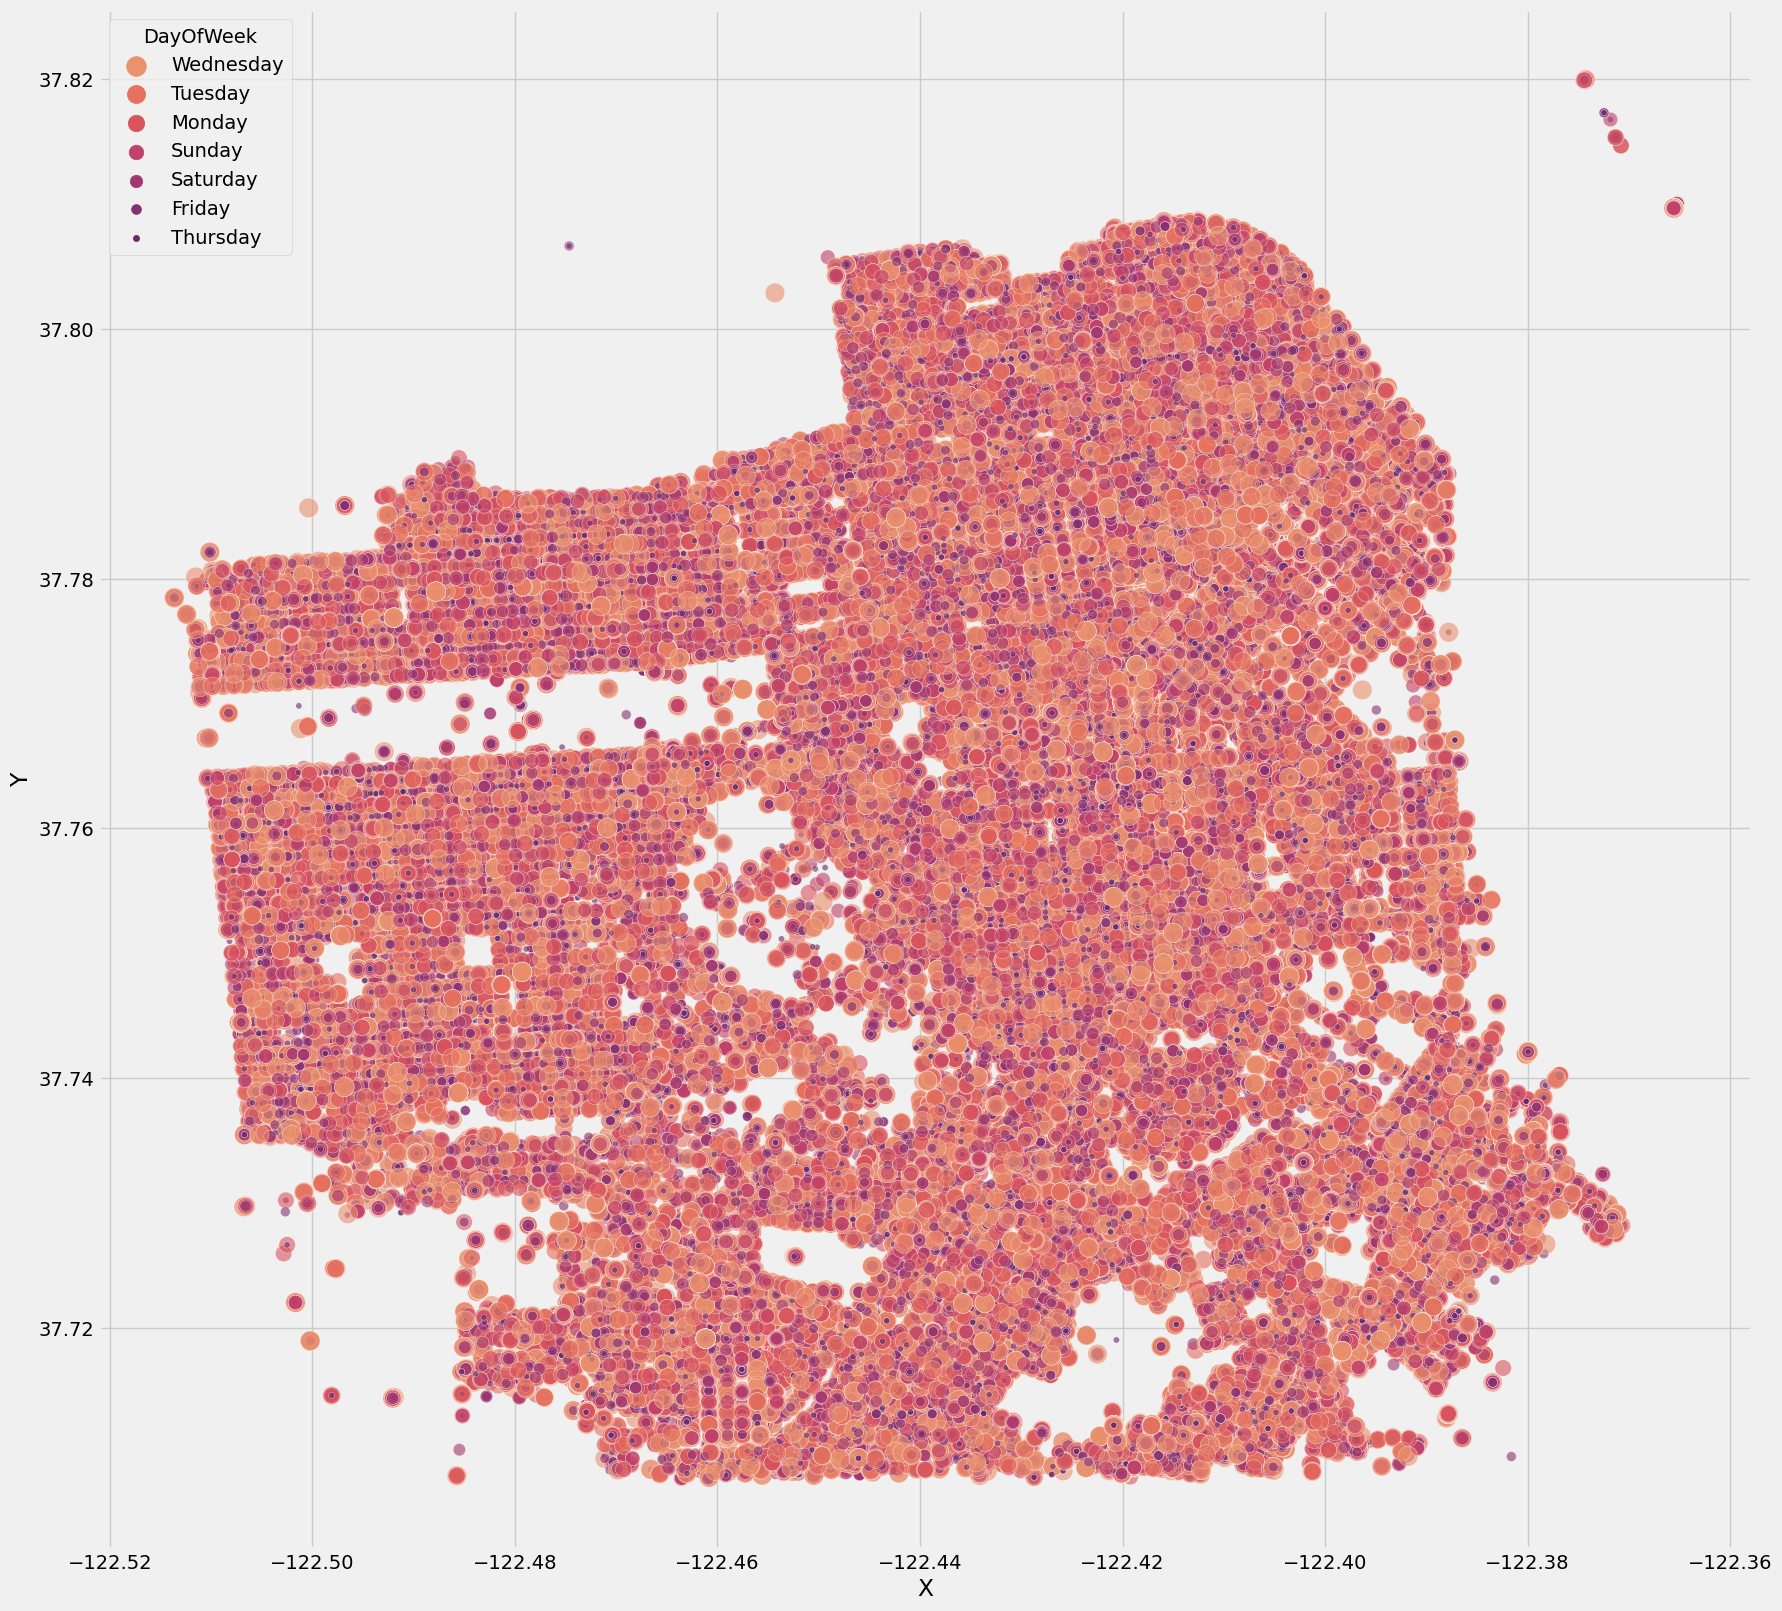

In [24]:
with plt.style.context('fivethirtyeight'):
    fig, ax = plt.subplots(1, 1, figsize=(19, 19))
    sns.scatterplot(data=df.iloc[:500000], x='X', y='Y', alpha=0.6, palette='flare', hue='DayOfWeek',
                    size='DayOfWeek', sizes=(20, 200), markers=True) # 878049

In [25]:
# df['Weekend'] = np.where((df['DayOfWeek']=='Sunday')|(df['DayOfWeek']=='Saturday'), 1, 0)
# df.head(100)

In [26]:
# print(df['Weekend'].value_counts()[0]/5, df['Weekend'].value_counts()[1]/2)

## Latitude (y) and longitude (x)

San Francisco Latitude and longitude coordinates are: 37.773972, -122.431297

 - southernmost position: 37.708086
 - northernmost position: 37.811324
 - westernmost position: -122.514675
 - easternmost position: -122.356859
 
 Source: Google Maps

In [27]:
df[['X', 'Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


In [28]:
# df_outliers = df.copy()
# df_outliers

In [29]:
# outliers = (df['X'] > -122.35)|(df['Y'] > 37.82)
# df_outliers.loc[outliers, ['X', 'Y']] = np.nan
# #df.info()
# outliers.value_counts()

In [30]:
# df_outliers.info()

In [31]:
# df_outliers.query('X>-122')

In [32]:
# df_outliers.info()

In [33]:
# geometry = [Point(xy) for xy in zip(train_data['X'], train_data['Y'])]
# gdf = GeoDataFrame(train_data, geometry=geometry)

# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(), marker='o', color='red')
# plt.show()

In [34]:
# m = folium.Map(location=[37.75, -122.45], zoom_start=12, tiles= 'Stamen Toner')

# folium.CircleMarker(
#     location=[37.780165, -122.403068],
#     radius=100,
#     popup=f'SOUTHERN\nLARCENY/THEFT',
#     color='blue',
#     fill=True,
#     fill_color='lightblue'
# ).add_to(m)

# m

## Exporting dataset

In [35]:
df.drop('Dates', axis=1, inplace=True)
df

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,month,day,year,hour
0,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,5,13,2015,23
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,5,13,2015,23
3,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,5,13,2015,23
4,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,5,13,2015,23
...,...,...,...,...,...,...,...,...,...,...,...,...
878044,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056,1,6,2003,0
878045,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948,1,6,2003,0
878046,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266,1,6,2003,0
878047,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607,1,6,2003,0


In [36]:
df.to_parquet(INTERIM_DATA + 'train.pqt', index=False)